# 🚨Preprocessing non a jour !🚨

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

In [24]:

# Charger les données
df = pd.read_csv("datas/train.csv")

# Fonction pour extraire les valeurs numériques
def extract_numeric(value):
    if isinstance(value, str):
        value = ''.join([c for c in value if c.isdigit() or c == '.'])
        return float(value) if value else None
    return value

# Conversion des colonnes contenant des nombres en format texte
df["Mileage"] = df["Mileage"].apply(extract_numeric)
df["Engine"] = df["Engine"].apply(extract_numeric)
df["Power"] = df["Power"].apply(extract_numeric)
df["New_Price"] = df["New_Price"].apply(extract_numeric)

# Extraire la marque depuis la colonne Name
df["Brand"] = df["Name"].apply(lambda x: x.split(" ")[0] if isinstance(x, str) else "Unknown")

# Suppression des colonnes inutiles
df.drop(columns=["Name", "New_Price"], inplace=True)

# Définition des colonnes numériques et catégoriques
num_features = ["Kilometers_Driven", "Mileage", "Power","Engine", "Seats"]
cat_features = ["Fuel_Type", "Transmission", "Owner_Type", "Location", "Brand"]

# Suppression des outliers avec IQR
for col in ["Price", "Power", "Engine"]:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

# Transformation logarithmique
for col in ["Price", "Power"]:
    df[col] = np.log1p(df[col])

# Création de nouvelles features
df["Vehicle_Age"] = 2025 - df["Year"]
df['Power_to_Engine'] = df['Power'] / df['Engine']
df['Usage_Per_Year'] = df['Kilometers_Driven'] / df["Vehicle_Age"]

# Pipeline pour les variables numériques
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Pipeline pour les variables catégoriques
cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

# Combinaison des transformations
preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_features),
    ("cat", cat_pipeline, cat_features)
])

# Transformation finale des données
X = df.drop(columns=["Price"])
y = df["Price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Transformation des données avec le préprocesseur
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)


In [21]:
X_train

,Location,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Brand,Vehicle_Age,Power_to_Engine,Usage_Per_Year
1182,Chennai,45000,Petrol,Manual,First,Renault,9,0.004999,5000.000000
3874,Hyderabad,45000,Diesel,Manual,First,Ford,10,0.003010,4500.000000
4538,Hyderabad,110009,Diesel,Manual,First,Skoda,15,0.002508,7333.933333
2936,Chennai,53713,Petrol,Manual,First,Toyota,10,0.003660,5371.300000
5712,Kolkata,18700,Petrol,Manual,Second,Maruti,18,0.004845,1038.888889
...,...,...,...,...,...,...,...,...,...
5752,Hyderabad,53000,Diesel,Manual,First,Honda,9,0.003072,5888.888889
657,Mumbai,18000,Petrol,Automatic,First,Honda,8,0.003189,2250.000000
4023,Kolkata,58000,Diesel,Manual,First,Hyundai,11,0.003064,5272.727273
4922,Kolkata,17000,Diesel,Automatic,First,Audi,17,0.002517,1000.000000


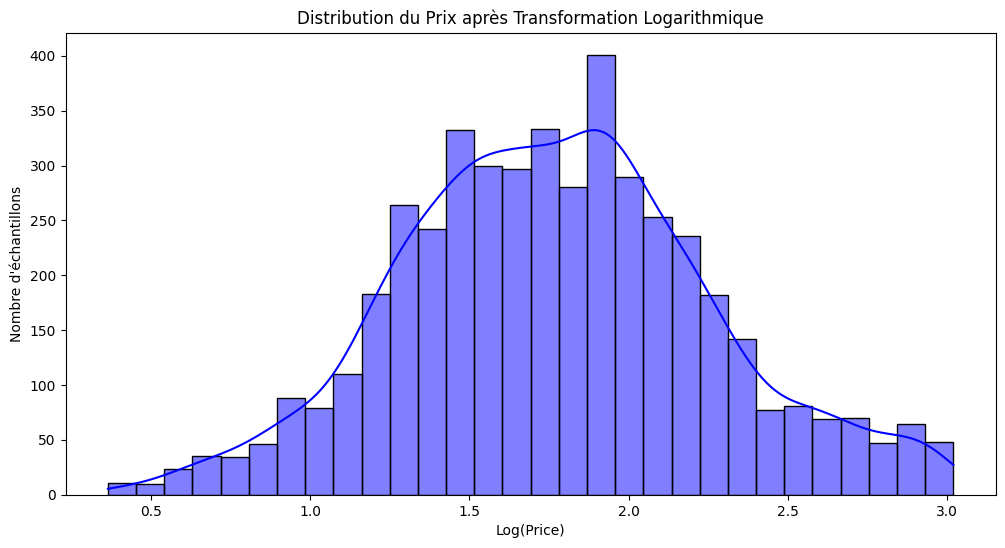

In [5]:
# Visualisation des distributions après preprocessing
plt.figure(figsize=(12, 6))
sns.histplot(df["Price"], kde=True, bins=30, color="blue")
plt.title("Distribution du Prix après Transformation Logarithmique")
plt.xlabel("Log(Price)")
plt.ylabel("Nombre d'échantillons")
plt.show()

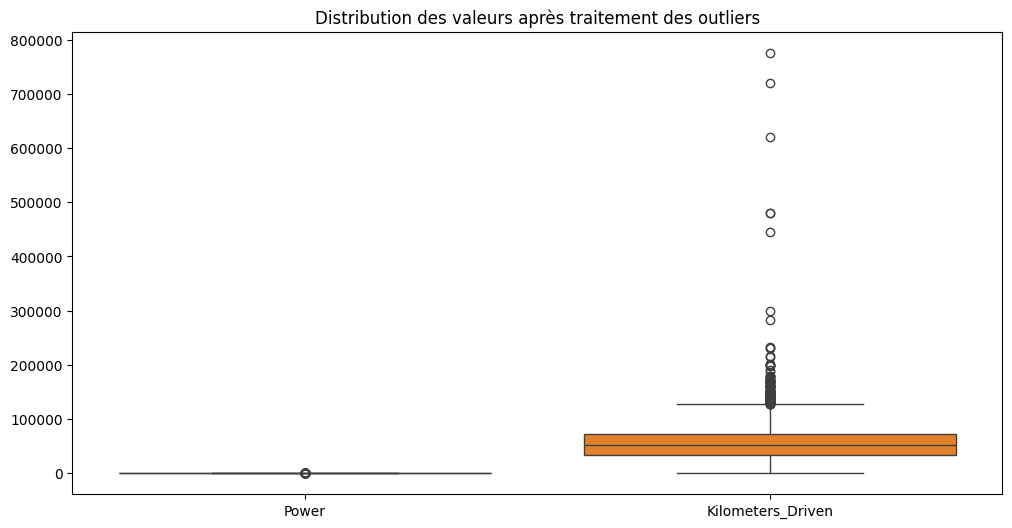

In [52]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[["Power", "Kilometers_Driven"]])
plt.title("Distribution des valeurs après traitement des outliers")
plt.show()

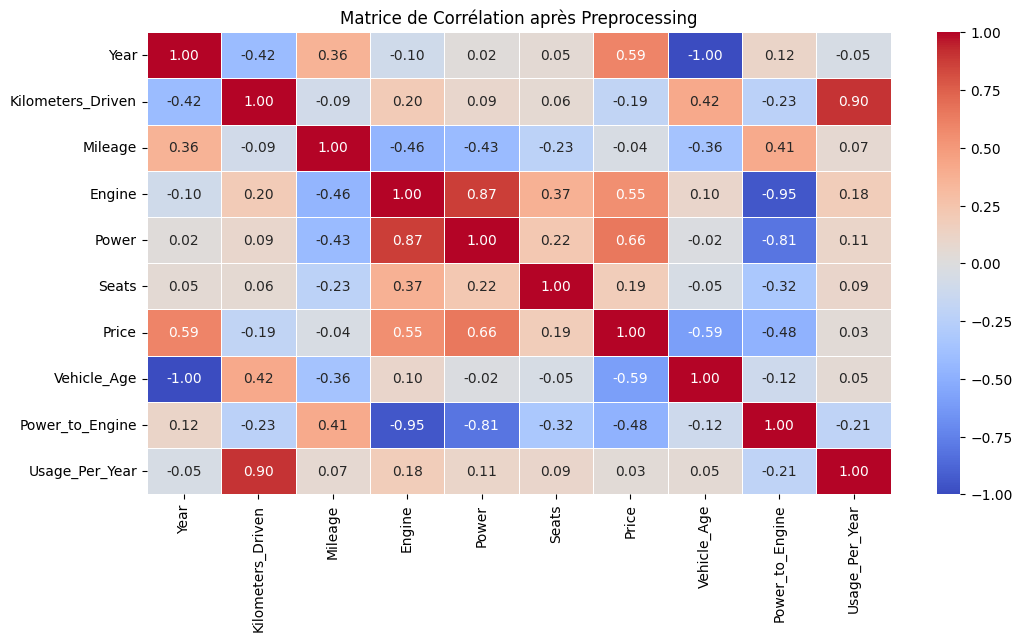

In [25]:
plt.figure(figsize=(12, 6))
sns.heatmap(df.select_dtypes(include=['number']).corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matrice de Corrélation après Preprocessing")
plt.show()

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Pipeline avec modèle RandomForest
rf_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(n_estimators=100, random_state=42))
])

# Pipeline avec modèle Linear Regression
lr_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LinearRegression())
])

# Pipeline avec modèle Support Vector Regression (SVR)
svr_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", SVR(kernel='rbf'))
])

# Entraînement des modèles
rf_pipeline.fit(X_train, y_train)
lr_pipeline.fit(X_train, y_train)
svr_pipeline.fit(X_train, y_train)

# Prédictions
y_pred_rf = rf_pipeline.predict(X_test)
y_pred_lr = lr_pipeline.predict(X_test)
y_pred_svr = svr_pipeline.predict(X_test)

# Évaluation des modèles
def evaluate_model(y_test, y_pred, model_name):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{model_name} - MAE: {mae}, MSE: {mse}, R² Score: {r2}")

# Afficher les performances
evaluate_model(y_test, y_pred_rf, "Random Forest")
evaluate_model(y_test, y_pred_lr, "Linear Regression")
evaluate_model(y_test, y_pred_svr, "SVR")


Random Forest - MAE: 0.14679894744211136, MSE: 0.039945256226486606, R² Score: 0.8369322113318676
Linear Regression - MAE: 0.19686927303033294, MSE: 0.06434000803744261, R² Score: 0.7373459623323477
SVR - MAE: 0.15941434300079207, MSE: 0.04317494676660964, R² Score: 0.8237477047292778
